# EmbedEvolution Stage 4: BERT Embeddings

Welcome to Stage 4! We now delve into BERT (Bidirectional Encoder Representations from Transformers). This marks a significant shift from static embeddings (Word2Vec, GloVe) and basic sequential models (RNNs) to powerful, deeply contextualized word representations. BERT leverages the Transformer architecture, specifically its encoder part, and is pre-trained on vast amounts of text using tasks like Masked Language Modeling (MLM) and Next Sentence Prediction (NSP).

The key feature of BERT is its ability to generate embeddings that change based on the surrounding words, truly capturing the meaning of a word in its specific context.

**Goal:** Understand how BERT generates contextual embeddings, observe how these embeddings differ for the same word in different sentences, and appreciate the advantages over static embedding methods.

## 1. Setup and Imports

We'll use the `transformers` library by Hugging Face and `torch`.

In [9]:
import torch
from transformers import BertTokenizerFast, BertModel
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import re

if torch.cuda.is_available():
    device_str = "cuda"
    print("CUDA is available. Using GPU (CUDA).")
# Check for Apple Silicon (MPS)
elif torch.backends.mps.is_available(): # This checks if MPS is available on the system
    device_str = "mps"
    print("MPS is available. Using Apple Silicon GPU (MPS).")
# Fallback to CPU
else:
    device_str = "cpu"
    print("CUDA and MPS not available. Using CPU.")

device = torch.device(device_str)
print(f"Selected device: {device}")

MPS is available. Using Apple Silicon GPU (MPS).
Selected device: mps


## 2. Load Pre-trained BERT Model and Tokenizer

We'll use a standard BERT model, for example, `bert-base-uncased` (all text is lowercased before tokenization).
The `BertTokenizerFast` is the recommended fast tokenizer.
`BertModel` is the core BERT model that outputs hidden states.

In [4]:
MODEL_NAME = 'bert-large-uncased' # Or 'bert-base-cased', 'bert-large-uncased', etc.

try:
    tokenizer = BertTokenizerFast.from_pretrained(MODEL_NAME)
    model = BertModel.from_pretrained(MODEL_NAME).to(device) # Move model to GPU if available
    model.eval() # Set model to evaluation mode (disables dropout, etc.)
    print(f"Successfully loaded BERT model ('{MODEL_NAME}') and tokenizer.")
except Exception as e:
    print(f"Error loading BERT model or tokenizer: {e}")
    model = None
    tokenizer = None

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Successfully loaded BERT model ('bert-large-uncased') and tokenizer.


## 3. Define Input Text and Core Comparison Sentences

To demonstrate BERT's contextual nature, we need sentences where our core words appear. The embedding for a word like "alice" or "rabbit" will be derived from its specific context within these sentences.
We'll use snippets from "Alice in Wonderland".

In [10]:
# The Alice text snippet (can be the same as before)
full_text_corpus = """
Alice was beginning to get very tired of sitting by her sister on the bank,
and of having nothing to do: once or twice she had peeped into the book her sister was reading,
but it had no pictures or conversations in it, 'and what is the use of a book,' thought Alice
'without pictures or conversation?' So she was considering in her own mind (as well as she could,
for the hot day made her feel very sleepy and stupid), whether the pleasure of making a
daisy-chain would be worth the trouble of getting up and picking the daisies,
when suddenly a White Rabbit with pink eyes ran close by her.

There was nothing so VERY remarkable in that; nor did Alice think it so VERY much out of the way
to hear the Rabbit say to itself, 'Oh dear! Oh dear! I shall be late!'
(when she thought it over afterwards, it occurred to her that she ought tohave wondered at this,
but at the time it all seemed quite natural); but when the Rabbit actually TOOK A WATCH OUT OF ITS
WAISTCOAT- POCKET, and looked at it, and then hurried on, Alice started to her feet, for it flashed
across her mind that she had never before seen a rabbit with either a waistcoat-pocket,
or a watch to take out of it, and burning with curiosity, she ran across the field after it,
and fortunately was just in time to see it pop down a large rabbit-hole under some hedge.
"""

# Select sentences for analysis. We'll target our core words within these contexts.
# These sentences will provide the context for our core_comparison_words.
# We aim for variety in context for some words.

sentences_for_analysis = [
    "Alice was beginning to get very tired.",                     # context for 'alice', 'tired' (our 'sleepy')
    "Her sister was reading a book.",                             # context for 'sister', 'book'
    "Suddenly a White Rabbit with pink eyes ran close by her.",   # context 1 for 'rabbit'
    "Alice had never before seen a rabbit with a watch.",         # context 2 for 'rabbit', context 1 for 'watch'
    "The Rabbit actually took a watch out of its pocket.",        # context 3 for 'rabbit', context 2 for 'watch'
    "Alice was burning with curiosity.",                          # context for 'curiosity'
    "It popped down a large rabbit-hole under some hedge."        # context for 'hedge'
]

# Core words we want to find embeddings for, within the sentences above.
# We will extract the embedding for the *first occurrence* of the word in its sentence.
# The 'key' will be used for plotting/comparison, 'target_word' is what we search for.
# 'sentence_idx' points to the sentences_for_analysis list.
core_contextual_words_info = {
    "alice_tired":    {"target_word": "alice",   "sentence_idx": 0},
    "sister_book":    {"target_word": "sister",  "sentence_idx": 1},
    "book_by_sister": {"target_word": "book",    "sentence_idx": 1},
    "rabbit_white":   {"target_word": "rabbit",  "sentence_idx": 2},
    "rabbit_with_watch": {"target_word": "rabbit", "sentence_idx": 3}, # rabbit in new context
    "watch_with_rabbit": {"target_word": "watch",   "sentence_idx": 3},
    "watch_in_pocket": {"target_word": "watch",   "sentence_idx": 4}, # watch in new context
    "curiosity_burning": {"target_word": "curiosity", "sentence_idx": 5},
    "sleepy_alice":   {"target_word": "tired",   "sentence_idx": 0, "display_name": "sleepy"}, # using 'tired' as proxy for 'sleepy'
    "hedge_hole":     {"target_word": "hedge",   "sentence_idx": 6},
}

## 4. Function to Get BERT Embeddings

This function will:
1.  Tokenize the input sentence(s).
2.  Pass them through the BERT model.
3.  Extract the hidden states from the last layer.
4.  For a specific target word in a sentence, find its token(s) and average their embeddings (to handle subword tokenization).
5.  Return the sentence embedding (e.g., mean of token embeddings or [CLS] token) and/or specific word embeddings.

In [11]:
def get_bert_embeddings(sentences, target_word_info=None, tokenizer_instance=None, model_instance=None):
    """
    Generates BERT embeddings for sentences and optionally for target words within those sentences.

    Args:
        sentences (list of str): Sentences to embed.
        target_word_info (dict, optional): Information about target words.
            Example: {"word_key": {"target_word": "actual_word", "sentence_idx": 0, "display_name": "optional_display_name"}}
            If None, only sentence embeddings are returned.
        tokenizer_instance: Pre-initialized BERT tokenizer.
        model_instance: Pre-initialized BERT model.

    Returns:
        tuple: (sentence_embeddings, word_embeddings_dict)
               sentence_embeddings (list of np.array): Embeddings for each sentence.
               word_embeddings_dict (dict): Embeddings for target words, keyed by word_key.
    """
    if not tokenizer_instance or not model_instance:
        raise ValueError("Tokenizer and model instances must be provided.")

    inputs = tokenizer_instance(sentences, padding=True, truncation=True, return_tensors="pt", return_offsets_mapping=True)
    offset_mapping = inputs.pop("offset_mapping") # Get offsets to map tokens to original words
    inputs = {k: v.to(device) for k, v in inputs.items()} # Move inputs to device

    with torch.no_grad():
        outputs = model_instance(**inputs)

    last_hidden_states = outputs.last_hidden_state.cpu() # Move to CPU for numpy conversion

    # Calculate sentence embeddings (mean pooling of token embeddings, ignoring [PAD])
    sentence_embeddings = []
    for i in range(len(sentences)):
        attention_mask = inputs['attention_mask'][i]
        sentence_hidden_states = last_hidden_states[i, (attention_mask == 1).cpu()]
        # Exclude [CLS] and [SEP] for sentence embedding if desired, or include. Here we include.
        # sentence_hidden_states = sentence_hidden_states[1:-1] if len(sentence_hidden_states) > 2 else sentence_hidden_states
        mean_pooled = torch.mean(sentence_hidden_states, dim=0).numpy()
        sentence_embeddings.append(mean_pooled)

    # Extract word embeddings if target_word_info is provided
    word_embeddings_dict = {}
    if target_word_info:
        for key, info in target_word_info.items():
            sentence_idx = info["sentence_idx"]
            target_word_str = info["target_word"]
            current_sentence_text = sentences[sentence_idx].lower() # Ensure consistency with uncased model
            token_ids_for_sentence = inputs['input_ids'][sentence_idx]

            word_token_indices = []
            # Find tokens corresponding to the target word
            # This is a simplified approach; robust mapping might require more care with subwords
            # For this demo, we find the first occurrence using string matching with offsets.
            # A more robust way would be to align tokens to words meticulously.
            start_char_idx = -1
            try:
                # Find the start character index of the first occurrence of the target word
                start_char_idx = current_sentence_text.find(target_word_str.lower())
            except AttributeError: # If current_sentence_text is not string
                 print(f"Error with sentence: {current_sentence_text}")
                 continue


            if start_char_idx != -1:
                end_char_idx = start_char_idx + len(target_word_str)
                for token_idx, (offset_start, offset_end) in enumerate(offset_mapping[sentence_idx]):
                    if offset_start == offset_end: continue # Skip special tokens like [CLS], [SEP], [PAD]
                    # Check if the token's span overlaps with the target word's span
                    if max(start_char_idx, offset_start) < min(end_char_idx, offset_end):
                        word_token_indices.append(token_idx)

            if word_token_indices:
                word_embeddings = last_hidden_states[sentence_idx, word_token_indices]
                # Average the embeddings of the subword tokens
                word_embedding_avg = torch.mean(word_embeddings, dim=0).numpy()
                word_embeddings_dict[key] = word_embedding_avg
            else:
                print(f"Warning: Target word '{target_word_str}' not found as expected in sentence {sentence_idx}: '{current_sentence_text}'. Skipping '{key}'.")
                # This can happen if tokenization breaks the word in an unexpected way or if offsets don't align perfectly.

    return sentence_embeddings, word_embeddings_dict

## 5. Generate and Explore BERT Embeddings

Let's get embeddings for our selected sentences and the target words within them.

In [12]:
if model and tokenizer:
    all_sentence_embeddings, specific_word_embeddings = get_bert_embeddings(
        sentences_for_analysis,
        core_contextual_words_info,
        tokenizer_instance=tokenizer,
        model_instance=model
    )

    print(f"\nGenerated {len(all_sentence_embeddings)} sentence embeddings.")
    print(f"Generated {len(specific_word_embeddings)} specific word embeddings.")

    # --- Demonstrate Contextual Nature ---
    print("\n--- Demonstrating Contextual Nature (Comparing 'rabbit' and 'watch') ---")
    if "rabbit_white" in specific_word_embeddings and "rabbit_with_watch" in specific_word_embeddings:
        sim_rabbits = cosine_similarity(
            specific_word_embeddings["rabbit_white"].reshape(1, -1),
            specific_word_embeddings["rabbit_with_watch"].reshape(1, -1)
        )[0][0]
        print(f"Similarity between 'rabbit' (in white rabbit context) and 'rabbit' (with watch context): {sim_rabbits:.4f}")
        # They should NOT be 1.0 if contexts are different.

    if "watch_with_rabbit" in specific_word_embeddings and "watch_in_pocket" in specific_word_embeddings:
        sim_watches = cosine_similarity(
            specific_word_embeddings["watch_with_rabbit"].reshape(1, -1),
            specific_word_embeddings["watch_in_pocket"].reshape(1, -1)
        )[0][0]
        print(f"Similarity between 'watch' (with rabbit context) and 'watch' (in pocket context): {sim_watches:.4f}")

    if "rabbit_white" in specific_word_embeddings and "watch_in_pocket" in specific_word_embeddings:
        sim_rabbit_watch = cosine_similarity(
            specific_word_embeddings["rabbit_white"].reshape(1, -1),
            specific_word_embeddings["watch_in_pocket"].reshape(1, -1)
        )[0][0]
        print(f"Similarity between 'rabbit' (white) and 'watch' (in pocket): {sim_rabbit_watch:.4f}")

    if "alice_tired" in specific_word_embeddings and "curiosity_burning" in specific_word_embeddings:
        sim_alice_curiosity = cosine_similarity(
            specific_word_embeddings["alice_tired"].reshape(1, -1),
            specific_word_embeddings["curiosity_burning"].reshape(1, -1)
        )[0][0]
        print(f"Similarity between 'alice' (tired) and 'curiosity' (burning): {sim_alice_curiosity:.4f}")

else:
    print("BERT Model or Tokenizer not loaded. Skipping embedding generation.")
    specific_word_embeddings = {} # Ensure it's defined for the next cell


Generated 7 sentence embeddings.
Generated 10 specific word embeddings.

--- Demonstrating Contextual Nature (Comparing 'rabbit' and 'watch') ---
Similarity between 'rabbit' (in white rabbit context) and 'rabbit' (with watch context): 0.8944
Similarity between 'watch' (with rabbit context) and 'watch' (in pocket context): 0.8812
Similarity between 'rabbit' (white) and 'watch' (in pocket): 0.4535
Similarity between 'alice' (tired) and 'curiosity' (burning): 0.2463


## 6. PCA Visualization of Contextual Word Embeddings

We'll visualize the embeddings of our `core_contextual_words_info` items. Each point will represent a word in its specific sentence context.

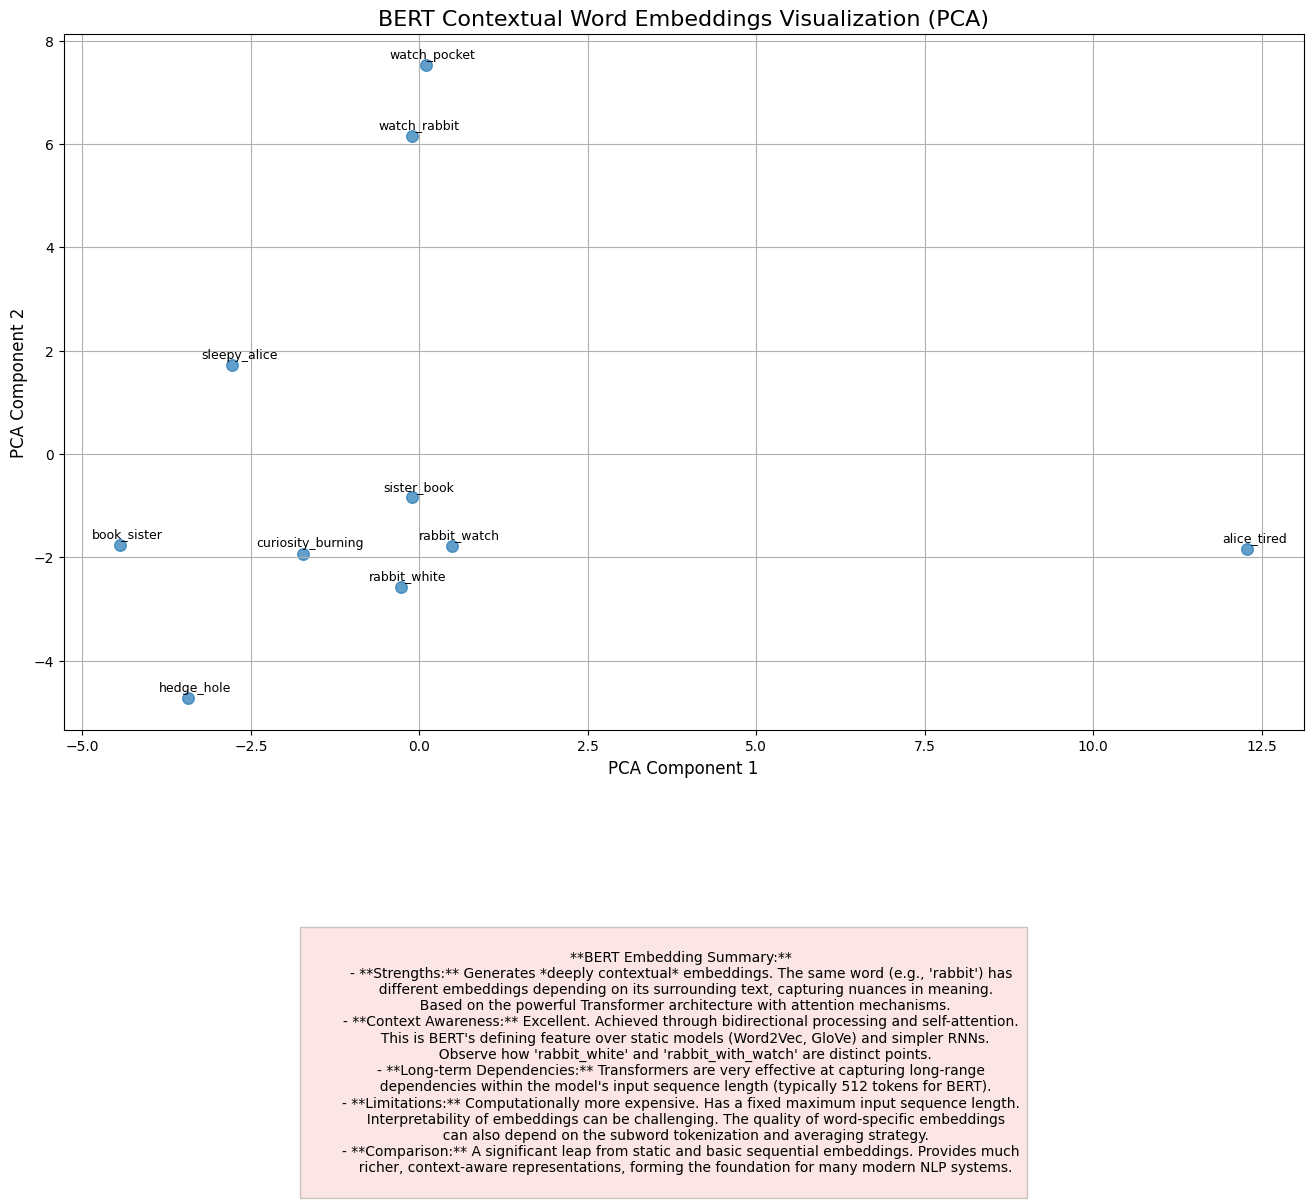

In [13]:
if specific_word_embeddings and len(specific_word_embeddings) >= 2:
    plot_labels = []
    embedding_list_for_pca = []

    for key, vector in specific_word_embeddings.items():
        display_name = core_contextual_words_info[key].get("display_name", core_contextual_words_info[key]["target_word"])
        # Make labels unique for plot if same display_name used for different contexts
        unique_label = f"{display_name}_{key.split('_')[-1]}" # e.g., rabbit_white, rabbit_watch
        plot_labels.append(unique_label)
        embedding_list_for_pca.append(vector)

    embedding_matrix_for_pca = np.array(embedding_list_for_pca)

    if embedding_matrix_for_pca.shape[0] >= 2: # Need at least 2 samples for PCA
        pca = PCA(n_components=2)
        embeddings_2d = pca.fit_transform(embedding_matrix_for_pca)

        plt.figure(figsize=(16, 12)) # Larger figure for more labels
        plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7, s=70)

        for i, label in enumerate(plot_labels):
            plt.annotate(label, (embeddings_2d[i, 0], embeddings_2d[i, 1]), textcoords="offset points", xytext=(5,5), ha='center', fontsize=9)

        plt.title('BERT Contextual Word Embeddings Visualization (PCA)', fontsize=16)
        plt.xlabel('PCA Component 1', fontsize=12)
        plt.ylabel('PCA Component 2', fontsize=12)
        plt.grid(True)

        summary_text = """
        **BERT Embedding Summary:**
        - **Strengths:** Generates *deeply contextual* embeddings. The same word (e.g., 'rabbit') has
          different embeddings depending on its surrounding text, capturing nuances in meaning.
          Based on the powerful Transformer architecture with attention mechanisms.
        - **Context Awareness:** Excellent. Achieved through bidirectional processing and self-attention.
          This is BERT's defining feature over static models (Word2Vec, GloVe) and simpler RNNs.
          Observe how 'rabbit_white' and 'rabbit_with_watch' are distinct points.
        - **Long-term Dependencies:** Transformers are very effective at capturing long-range
          dependencies within the model's input sequence length (typically 512 tokens for BERT).
        - **Limitations:** Computationally more expensive. Has a fixed maximum input sequence length.
          Interpretability of embeddings can be challenging. The quality of word-specific embeddings
          can also depend on the subword tokenization and averaging strategy.
        - **Comparison:** A significant leap from static and basic sequential embeddings. Provides much
          richer, context-aware representations, forming the foundation for many modern NLP systems.
        """
        plt.figtext(0.5, -0.08, summary_text, ha="center", fontsize=10, bbox={"facecolor":"lightcoral", "alpha":0.2, "pad":5}, wrap=True)
        plt.subplots_adjust(bottom=0.3) # Adjust layout
        plt.show()
    else:
        print("Not enough embeddings to perform PCA (need at least 2).")
else:
    print("No specific word embeddings generated or too few to plot. Skipping PCA visualization.")

## 7. Discussion

In this notebook, we used a pre-trained BERT model to generate contextual embeddings.

- **Key Observation:** The core demonstration was showing that the vector representation for a word like "rabbit" changes based on its surrounding sentence context. This is evident if `sim_rabbits` (and `sim_watches`) is less than 1.0. This dynamism is what makes BERT and other Transformer-based models so powerful.
- **PCA Plot Insights:** The PCA plot visualizes these contextual instances. Words in very different contexts should appear further apart. Words used in similar contextual roles might cluster closer, even if they are different words. The plot now shows specific instances like "rabbit\_white" and "rabbit\_with\_watch" as separate points.
- **Beyond Word Embeddings:** BERT's `[CLS]` token embedding (the first token's output) is often used as an aggregate representation for the entire input sequence, especially for classification tasks. We used mean pooling here for sentence embeddings, another common technique.

**Next Steps:** BERT opened the door to a wide array of Transformer models. Further stages in EmbedEvolution could explore:
- **Sentence-BERT (Sentence Transformers):** Fine-tuning BERT (or other Transformers) specifically to create semantically meaningful sentence embeddings that can be easily compared using cosine similarity.
- **More recent models:** Exploring variants like RoBERTa, ELECTRA, or domain-specific BERTs.
- **Instruction-tuned models (like InstructOR):** Models trained to follow instructions, which can be powerful for generating tailored embeddings based on task descriptions.